<img src = "imgs/TeS_img.png">

For this example, you will need to install cyipopt:

```python
%pip install cyipopt
```

Gibbs Energy Minimization using Virial EOS with IPOPT
Initial composition: H2O=1.0, CH4=0.5 mol
Pressure: 10 bar
Temperature range: 773-1273 K
------------------------------------------------------------
Progress: 1/30 temperatures completed
Progress: 5/30 temperatures completed
Progress: 10/30 temperatures completed
Progress: 15/30 temperatures completed
Progress: 20/30 temperatures completed
Progress: 25/30 temperatures completed
Progress: 30/30 temperatures completed
------------------------------------------------------------
Optimization completed!
Successful convergence: 6/30 points

RESULTS SUMMARY

First 3 temperature points:

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***************************************************

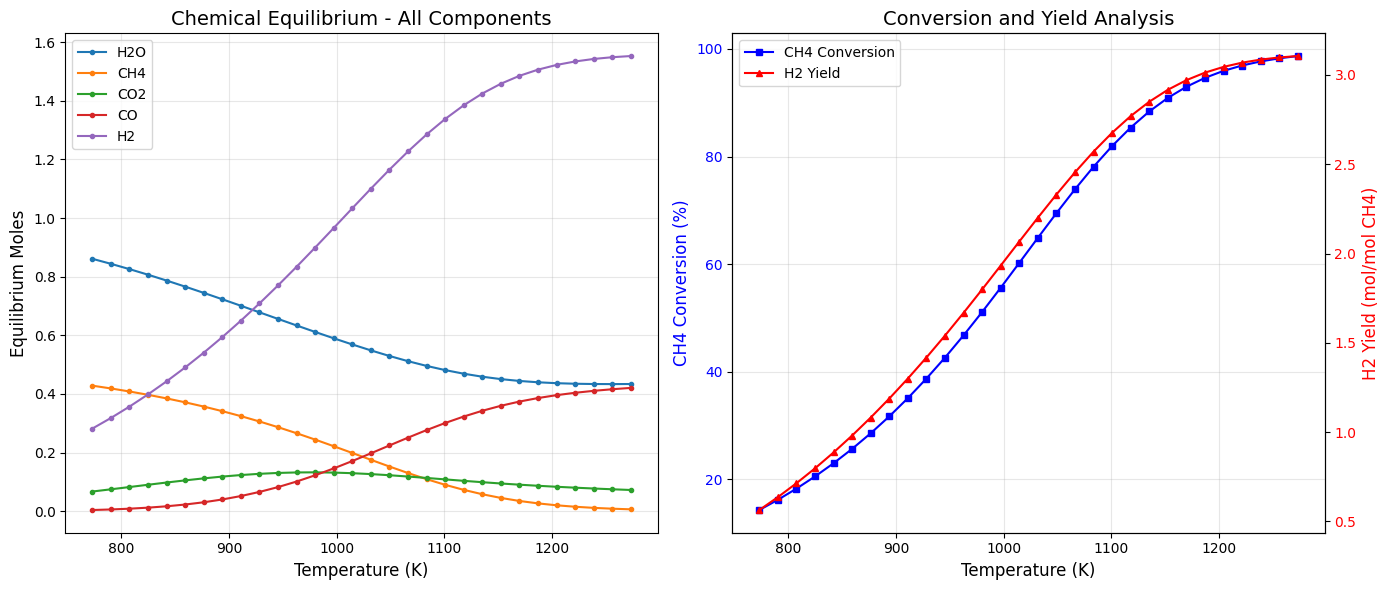


EQUILIBRIUM COMPOSITION AT KEY TEMPERATURES

T = 773 K:
  H2O: 0.8611 mol
  CH4: 0.4284 mol
  CO2: 0.0673 mol
  CO : 0.0043 mol
  H2 : 0.2820 mol
  CH4 conversion: 14.3%
  H2 yield: 0.56 mol/mol CH4

T = 1014 K:
  H2O: 0.5689 mol
  CH4: 0.1988 mol
  CO2: 0.1299 mol
  CO : 0.1713 mol
  H2 : 1.0334 mol
  CH4 conversion: 60.2%
  H2 yield: 2.07 mol/mol CH4

T = 1273 K:
  H2O: 0.4340 mol
  CH4: 0.0066 mol
  CO2: 0.0726 mol
  CO : 0.4208 mol
  H2 : 1.5527 mol
  CH4 conversion: 98.7%
  H2 yield: 3.11 mol/mol CH4


In [1]:
"""
Chemical Equilibrium via Gibbs Energy Minimization
Components: H2O, CH4, CO2, CO, H2
Using Virial EOS with IPOPT solver
"""

import numpy as np
import cyipopt
from scipy.integrate import quad
import pandas as pd
import matplotlib.pyplot as plt

# ==================== THERMODYNAMIC DATA ====================

# 1.1. Heat capacities
# CPA, CPB, CPC, CPD
CP_data = np.array([
    [3.47, 0.00145, 0, 12100],           # H2O
    [1.702, 0.009081, -0.000002164, 0],  # CH4
    [5.457, 0.001045, 0, -115700],       # CO2
    [3.376, 0.000557, 0, -3100],         # CO
    [3.249, 0.000422, 0, 8300]           # H2
])

# 1.2. Thermodynamic Properties of Formation
# deltaH (J/mol), deltaG (J/mol) at 298.15 K
prop_form = np.array([
    [-241818, -228572],    # H2O
    [-74520, -50460],      # CH4
    [-393509, -394359],    # CO2
    [-110525, -137169],    # CO
    [0, 0]                 # H2
])

# 1.3. Critical Properties with Volume
# Pc (bar), Tc (K), omega (-), Vc (cm³/mol)
prop_term = np.array([
    [220.55, 647.1, 0.345, 56.0],    # H2O
    [45.99, 190.6, 0.012, 98.6],     # CH4
    [73.83, 304.2, 0.224, 94.0],     # CO2
    [34.99, 132.9, 0.048, 93.1],     # CO
    [13.13, 33.19, -0.216, 64.5]     # H2
])

# ==================== THERMODYNAMIC FUNCTIONS ====================

def gibbs_pad(T, prop_form, CP_data):
    """Calculate standard Gibbs energy of formation at temperature T"""
    R = 8.314  # J/mol·K
    T0 = 298.15  # Reference temperature in Kelvin
    
    results = []
    
    for i in range(len(prop_form)):
        deltaH = prop_form[i, 0]
        deltaG = prop_form[i, 1]
        CPA, CPB, CPC, CPD = CP_data[i]
        
        def cp(T_prime):
            return R * (CPA + CPB * T_prime + CPC * T_prime**2 + CPD / T_prime**2)
        
        def inner_integral(T_prime):
            value, _ = quad(cp, T0, T_prime)
            return (deltaH + value) / T_prime**2
        
        integral_value, _ = quad(inner_integral, T0, T)
        mu_i = T * (deltaG / T0 - integral_value)
        results.append(mu_i)
    
    return np.array(results)

def fug(T, P, n, prop_term):
    """
    Calculate fugacity coefficients using Virial equation of state
    prop_term: [[Pc, Tc, omega, Vc], ...] where Vc in cm³/mol
    """
    P_pa = P * 100000  # bar -> Pa
    R = 8.314  # J/(mol*K)
    
    # Avoid division by zero
    n_safe = np.maximum(n, 1e-20)
    y = n_safe / np.sum(n_safe)  # mole fractions
    
    # Component properties
    Pc = prop_term[:, 0] * 100000  # bar -> Pa
    Tc = prop_term[:, 1]
    omega = prop_term[:, 2]
    Vc = prop_term[:, 3] / 1e6  # cm³/mol -> m³/mol
    
    nc = len(n)
    B = np.zeros((nc, nc))
    
    # Calculate virial coefficient matrix Bij
    for i in range(nc):
        for j in range(nc):
            # kij based on critical volume
            if i != j:
                kij = 1 - 2*np.sqrt(Vc[i]*Vc[j])/((Vc[i]**(1/3) + Vc[j]**(1/3))/2)**3
                kij = np.clip(kij, -0.5, 0.5)  # Limit kij to reasonable values
            else:
                kij = 0
            
            # Mixing rules
            Tcij = np.sqrt(Tc[i] * Tc[j]) * (1 - kij)
            Pcij = R * Tcij * (0.5*(Vc[i]**(-1/3) + Vc[j]**(-1/3)))**3
            wij = 0.5 * (omega[i] + omega[j])
            
            # Pitzer correlation
            Tr = T / Tcij
            B0 = 0.083 - 0.422 / Tr**1.6
            B1 = 0.139 - 0.172 / Tr**4.2
            B[i,j] = (R * Tcij / Pcij) * (B0 + wij * B1)
    
    # Fugacity coefficients
    B_mix = y @ B @ y
    ln_phi = (2 * B @ y - B_mix) * P_pa / (R * T)
    
    return np.exp(ln_phi)

# ==================== OPTIMIZATION PROBLEM CLASS ====================

class GibbsMinimization:
    def __init__(self, T, P, n0):
        self.T = T
        self.P = P
        self.n0 = np.array(n0)
        self.R = 8.314
        
        # Element balance matrix (components x elements)
        # [C, H, O]
        self.A = np.array([
            [0, 2, 1],  # H2O
            [1, 4, 0],  # CH4
            [1, 0, 2],  # CO2
            [1, 0, 1],  # CO
            [0, 2, 0]   # H2
        ])
        
        # Initial element amounts
        self.b0 = np.dot(self.n0, self.A)
        
        # Calculate bounds based on element conservation
        max_C = self.b0[0]  # Total carbon
        max_H = self.b0[1]  # Total hydrogen
        max_O = self.b0[2]  # Total oxygen
        
        self.lb = np.zeros(5)
        self.ub = np.array([
            min(max_O, max_H/2),      # max H2O
            min(max_C, max_H/4),      # max CH4
            min(max_C, max_O/2),      # max CO2
            min(max_C, max_O),        # max CO
            max_H/2                   # max H2
        ])
        
        # Pre-calculate standard Gibbs energies
        self.dfg_gas = gibbs_pad(self.T, prop_form, CP_data)
    
    def objective(self, n):
        """Gibbs energy objective function"""
        # Avoid numerical issues
        n_safe = np.maximum(n, 1e-20)
        
        # Calculate fugacity coefficients
        phi = fug(self.T, self.P, n_safe, prop_term)
        
        # Calculate chemical potential for each component
        mi = self.dfg_gas + self.R * self.T * (
            np.log(phi) + 
            np.log(n_safe / np.sum(n_safe)) + 
            np.log(self.P)
        )
        
        # Total Gibbs energy
        return np.sum(mi * n_safe)
    
    def gradient(self, n):
        """Gradient of Gibbs energy"""
        eps = 1e-8
        grad = np.zeros_like(n)
        
        for i in range(len(n)):
            n_plus = n.copy()
            n_plus[i] += eps
            
            n_minus = n.copy()
            n_minus[i] = max(n[i] - eps, 1e-20)
            
            grad[i] = (self.objective(n_plus) - self.objective(n_minus)) / (2 * eps)
        
        return grad
    
    def constraints(self, n):
        """Element balance constraints"""
        return np.dot(n, self.A) - self.b0
    
    def jacobian(self, n):
        """Jacobian of constraints (constant for linear constraints)"""
        return self.A.T.flatten()

# ==================== OPTIMIZATION FUNCTION ====================

def optimize_gibbs_ipopt(T, P, n0, initial_guess=None):
    """
    Minimize Gibbs energy using IPOPT
    
    Parameters:
    -----------
    T : float
        Temperature (K)
    P : float
        Pressure (bar)
    n0 : array-like
        Initial moles of each component
    initial_guess : array-like, optional
        Initial guess for optimization
    
    Returns:
    --------
    x : array
        Equilibrium composition (moles)
    info : dict
        Optimization information
    """
    
    problem = GibbsMinimization(T, P, n0)
    
    # Problem dimensions
    n_vars = 5  # number of components
    n_cons = 3  # number of elements (C, H, O)
    
    # Create IPOPT problem
    nlp = cyipopt.Problem(
        n=n_vars,
        m=n_cons,
        problem_obj=problem,
        lb=problem.lb,
        ub=problem.ub,
        cl=np.zeros(n_cons),  # equality constraints
        cu=np.zeros(n_cons),  # equality constraints
    )
    
    # Set IPOPT options
    nlp.add_option('mu_strategy', 'adaptive')
    nlp.add_option('tol', 1e-8)
    nlp.add_option('print_level', 0)
    nlp.add_option('max_iter', 1000)
    nlp.add_option('hessian_approximation', 'limited-memory')
    nlp.add_option('warm_start_init_point', 'yes')
    
    # Initial guess
    if initial_guess is None:
        # Smart initial guess based on stoichiometry
        x0 = np.array([0.5, 0.1, 0.2, 0.1, 0.1])
    else:
        x0 = initial_guess
    
    # Ensure initial guess satisfies bounds
    x0 = np.clip(x0, problem.lb + 1e-6, problem.ub - 1e-6)
    
    # Solve
    x, info = nlp.solve(x0)
    
    return x, info

# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    # Initial composition (moles)
    n0 = [1.0, 0.5, 0.0, 0.0, 0.0]  # H2O, CH4, CO2, CO, H2
    
    # Temperature range
    Tmin = 773
    Tmax = 1273
    ntemp = 30
    T_range = np.linspace(Tmin, Tmax, ntemp)
    
    # Pressure
    P = 10  # bar
    
    # Storage for results
    results = []
    temperatures = []
    converged = []
    
    # Initial guess for first temperature
    init_guess = np.array([0.5, 0.2, 0.1, 0.1, 0.1])
    
    print("=" * 60)
    print("Gibbs Energy Minimization using Virial EOS with IPOPT")
    print("=" * 60)
    print(f"Initial composition: H2O={n0[0]:.1f}, CH4={n0[1]:.1f} mol")
    print(f"Pressure: {P} bar")
    print(f"Temperature range: {Tmin}-{Tmax} K")
    print("-" * 60)
    
    # Solve for each temperature
    for i, T in enumerate(T_range):
        try:
            # Solve optimization
            solution, info = optimize_gibbs_ipopt(T, P, n0, init_guess)
            
            # Check convergence
            if info['status'] == 0:  # Successful convergence
                converged.append(True)
                # Use current solution as initial guess for next temperature
                init_guess = solution.copy()
            else:
                converged.append(False)
                print(f"Warning: Convergence issue at T={T:.1f} K")
            
            # Store results
            results.append(solution)
            temperatures.append(T)
            
            # Progress update
            if (i + 1) % 5 == 0 or i == 0:
                print(f"Progress: {i + 1}/{ntemp} temperatures completed")
        
        except Exception as e:
            print(f"Error at T={T:.2f} K: {e}")
            results.append(init_guess)
            temperatures.append(T)
            converged.append(False)
    
    print("-" * 60)
    print("Optimization completed!")
    print(f"Successful convergence: {sum(converged)}/{len(converged)} points")
    
    # Create DataFrame with results
    components = ['H2O', 'CH4', 'CO2', 'CO', 'H2']
    df_results = pd.DataFrame(results, columns=components)
    df_results['Temperature (K)'] = temperatures
    df_results['Converged'] = converged
    df_results.set_index('Temperature (K)', inplace=True)
    
    # Display results summary
    print("\n" + "=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)
    print("\nFirst 3 temperature points:")
    print(df_results[components].head(3))
    print("\nLast 3 temperature points:")
    print(df_results[components].tail(3))
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: All components
    for comp in components:
        ax1.plot(df_results.index, df_results[comp], 
                label=comp, marker='o', markersize=3)
    
    ax1.set_xlabel('Temperature (K)', fontsize=12)
    ax1.set_ylabel('Equilibrium Moles', fontsize=12)
    ax1.set_title('Chemical Equilibrium - All Components', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Conversion analysis
    conv_CH4 = (n0[1] - df_results['CH4']) / n0[1] * 100
    yield_H2 = df_results['H2'] / n0[1]  # mol H2 per mol CH4 initial
    
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(df_results.index, conv_CH4, 
                    'b-', label='CH4 Conversion', marker='s', markersize=4)
    line2 = ax2_twin.plot(df_results.index, yield_H2, 
                         'r-', label='H2 Yield', marker='^', markersize=4)
    
    ax2.set_xlabel('Temperature (K)', fontsize=12)
    ax2.set_ylabel('CH4 Conversion (%)', fontsize=12, color='b')
    ax2_twin.set_ylabel('H2 Yield (mol/mol CH4)', fontsize=12, color='r')
    ax2.set_title('Conversion and Yield Analysis', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='b')
    ax2_twin.tick_params(axis='y', labelcolor='r')
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='best')
    
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print equilibrium at key temperatures
    print("\n" + "=" * 60)
    print("EQUILIBRIUM COMPOSITION AT KEY TEMPERATURES")
    print("=" * 60)
    
    key_temps = [773, 1023, 1273]
    for T_key in key_temps:
        idx = np.argmin(np.abs(T_range - T_key))
        print(f"\nT = {T_range[idx]:.0f} K:")
        for comp, value in zip(components, results[idx]):
            print(f"  {comp:3s}: {value:.4f} mol")
        print(f"  CH4 conversion: {(n0[1] - results[idx][1])/n0[1]*100:.1f}%")
        print(f"  H2 yield: {results[idx][4]/n0[1]:.2f} mol/mol CH4")